# Assignment 3

    Author: Group F - Gaurav, Xiaowen Sun, Jheel Harnish Kamdar, Ruijia Xiong
    Created at: 03/10/2024

For this assignment, we're choosing
- Beauty;
- Digital Music;
- Patio Lawn, and Gardern;

three datasets. There are 276480 reviews in total of the three datasets combined.

In [ ]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import gzip
import json
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from gensim.models import Word2Vec, FastText
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt


## 1. Data Preprocessing

### 1.1 Load dataset and Initial exploration

In [ ]:
# Function to load a single dataset
def load_dataset(file_name):
    with gzip.open(file_name, 'r') as f:
        data = [json.loads(line) for line in f]
    return pd.DataFrame(data)

# List of dataset files
files = [
    'reviews_Beauty_5.json.gz',
    'reviews_Digital_Music_5.json.gz',
    'reviews_Patio_Lawn_and_Garden_5.json.gz'
]

# Load and concatenate the datasets
df_list = [load_dataset(f'/content/{file}') for file in files]
df = pd.concat(df_list, ignore_index=True)

# Display the shape and the first few rows of the combined dataframe
print(f'DataFrame shape: {df.shape}')
print(df.info())
df.head()

DataFrame shape: (276480, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276480 entries, 0 to 276479
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      276480 non-null  object 
 1   asin            276480 non-null  object 
 2   reviewerName    274752 non-null  object 
 3   helpful         276480 non-null  object 
 4   reviewText      276480 non-null  object 
 5   overall         276480 non-null  float64
 6   summary         276480 non-null  object 
 7   unixReviewTime  276480 non-null  int64  
 8   reviewTime      276480 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 19.0+ MB
None


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013"


### 1.2 Clean the text data

In [ ]:
# Function to clean the review text
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()              # Lowercase the text
    text = re.sub(r'\d+', '', text)  # Remove numbers
    tokens = word_tokenize(text)     # Tokenize the text
    filtered_words = [word for word in tokens if word not in stopwords.words('english')] # Remove stopwords
    text = ' '.join(filtered_words)  # Join the words back into one string
    return text

# Preprocess and clean the review texts
df['cleaned_reviewText'] = df['reviewText'].apply(clean_text)

In [ ]:
df.head()

(276480, 10)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,cleaned_reviewText
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014",oily creamy expected ordered try highlight con...
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014",palette decent price looking different shades ...
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013",texture concealer pallet fantastic great cover...
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013",really tell exactly thing powder kind oil ish ...
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013",little smaller expected okay lasted long time ...


In [ ]:
df = df.dropna(subset=['reviewText', 'cleaned_reviewText'])

## 2. Word2Vec, fasttext Embeddings


### 2.1 Create 100D vectors using Word2Vec(CBOW, SkipGram), and fasttext

In [ ]:
from gensim.models import Word2Vec, FastText
from nltk.tokenize import word_tokenize

# Tokenize the cleaned review texts
tokenized_reviews = [word_tokenize(review) for review in df['cleaned_reviewText']]

# Create Word2Vec CBOW embeddings
w2v_model_cbow = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, sg=0)

# Create Word2Vec SkipGram model
w2v_model_sg = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, sg=1)

# Create FastText embeddings
fasttext_model = FastText(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, sg=1)

### 2.2 Average the vectors

In [ ]:
# Function to average word vectors for a text
def average_vector(words, model):
    vector_list = [model.wv[word] for word in words if word in model.wv]

    if not vector_list:
        return np.zeros(vector_size)
    else:
        return np.mean(vector_list, axis=0)

vector_size = 100

# Compute average vectors for each model
df['w2v_cbow_avg_vector'] = [average_vector(review, w2v_model_cbow) for review in tokenized_reviews]
df['w2v_sg_avg_vector'] = [average_vector(review, w2v_model_sg) for review in tokenized_reviews]
df['fasttext_avg_vector'] = [average_vector(review, fasttext_model) for review in tokenized_reviews]

In [ ]:
df = df.reset_index(drop=True)

### 2.3 EDA to analyze associations between vectors - Cosine Similarity

In [ ]:
df['w2v_cbow_avg_vector'] = df['w2v_cbow_avg_vector'].reset_index(drop=True)
df['w2v_sg_avg_vector'] = df['w2v_sg_avg_vector'].reset_index(drop=True)
df['fasttext_avg_vector'] = df['fasttext_avg_vector'].reset_index(drop=True)

#### 2.3.1 Cosine Similarity #1


*   Calculate each row cosine similarity manully and then compute the mean of each row

In [ ]:
cbow_sg = []
cbow_fasttext = []
sg_fasttext = []
for i in range(len(df['w2v_cbow_avg_vector'])):
    c1 = np.array([df['w2v_cbow_avg_vector'][i]])
    c2 = np.array([df['w2v_sg_avg_vector'][i]])
    c3 = np.array([df['fasttext_avg_vector'][i]])

    cbow_sg.append(cosine_similarity(c1, c2))
    cbow_fasttext.append(cosine_similarity(c1, c3))
    sg_fasttext.append(cosine_similarity(c2, c3))
print(f'Cosine Similarity cbow and sg: {np.mean(cbow_sg)}')
print(f'Cosine Similarity cbow and fasttext: {np.mean(cbow_fasttext)}')
print(f'Cosine Similarity fasttext and sg: {np.mean(sg_fasttext)}')

Cosine Similarity cbow and sg: -0.09998832643032074
Cosine Similarity cbow and fasttext: -0.09714201092720032
Cosine Similarity fasttext and sg: 0.05453105270862579


#### 2.3.2 Cosine Similarity #2
* Use batch processing to calculate the cosine similarity since the whole dataset is too big to compute

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Define batch size
batch_size = 1000

# Calculate total number of batches
num_batches = len(df) // batch_size + (1 if len(df) % batch_size != 0 else 0)

# Initialize lists to store average cosine similarity for each batch
avg_sim_cbow_sg_list = []
avg_sim_cbow_fasttext_list = []
avg_sim_sg_fasttext_list = []

# Iterate over batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df))

    # Convert batch of vectors to NumPy matrix for each model
    w2v_cbow_matrix = np.array(df['w2v_cbow_avg_vector'][start_idx:end_idx].tolist())
    w2v_sg_matrix = np.array(df['w2v_sg_avg_vector'][start_idx:end_idx].tolist())
    fasttext_matrix = np.array(df['fasttext_avg_vector'][start_idx:end_idx].tolist())

    # Calculate cosine similarity between the average vectors of each pair models
    cosine_sim_cbow_sg = cosine_similarity(w2v_cbow_matrix, w2v_sg_matrix)
    cosine_sim_cbow_fasttext = cosine_similarity(w2v_cbow_matrix, fasttext_matrix)
    cosine_sim_sg_fasttext = cosine_similarity(w2v_sg_matrix, fasttext_matrix)

    # Since cosine_similarity returns a matrix, you can take the average to get a single similarity measure
    # between the entire sets of vectors for each model comparison
    avg_sim_cbow_sg_list.append(np.mean(cosine_sim_cbow_sg))
    avg_sim_cbow_fasttext_list.append(np.mean(cosine_sim_cbow_fasttext))
    avg_sim_sg_fasttext_list.append(np.mean(cosine_sim_sg_fasttext))

# Compute overall average cosine similarity for each model comparison
avg_sim_cbow_sg = np.mean(avg_sim_cbow_sg_list)
avg_sim_cbow_fasttext = np.mean(avg_sim_cbow_fasttext_list)
avg_sim_sg_fasttext = np.mean(avg_sim_sg_fasttext_list)

print(f"Average Cosine Similarity between Word2Vec CBOW and Skip-Gram: {avg_sim_cbow_sg}")
print(f"Average Cosine Similarity between Word2Vec CBOW and FastText: {avg_sim_cbow_fasttext}")
print(f"Average Cosine Similarity between Word2Vec Skip-Gram and FastText: {avg_sim_sg_fasttext}")


Average Cosine Similarity between Word2Vec CBOW and Skip-Gram: -0.21282580494880676
Average Cosine Similarity between Word2Vec CBOW and FastText: -0.11413481086492538
Average Cosine Similarity between Word2Vec Skip-Gram and FastText: 0.04300118610262871


## 3. Sentiment Analysis

#### 3.1 Use overall rating
• 1: Positive

• 0: Negative

In [ ]:
# Remove entries with a rating of 3 as they are considered neutral
df = df[df['overall'] != 3]

# Convert ratings into binary sentiment (1&2 = Negative-0, 4&5 = Positive-1)
df['sentiment'] = df['overall'].apply(lambda x: 1 if x > 3 else 0)

### 3.2 Train test split

In [ ]:
# Split df into training and testing sets before feature extraction
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

X_train_cbow = np.array(df_train['w2v_cbow_avg_vector'].tolist())
X_train_sg = np.array(df_train['w2v_sg_avg_vector'].tolist())
X_train_fasttext = np.array(df_train['fasttext_avg_vector'].tolist())
y_train = df_train['sentiment'].values

X_test_cbow = np.array(df_test['w2v_cbow_avg_vector'].tolist())
X_test_sg = np.array(df_test['w2v_sg_avg_vector'].tolist())
X_test_fasttext = np.array(df_test['fasttext_avg_vector'].tolist())
y_test = df_test['sentiment'].values

print("Shape of X_train:", X_train_cbow.shape, X_train_sg.shape, X_train_fasttext.shape)
print("Shape of X_test:", X_test_cbow.shape, X_test_sg.shape, X_test_fasttext.shape)


Shape of X_train: (196592, 100) (196592, 100) (196592, 100)
Shape of X_test: (49149, 100) (49149, 100) (49149, 100)


### 3.3 Dimensionality Reduction

In [ ]:
def pca(X_train, title):
    pca = PCA(n_components=100)
    X_reduced = pca.fit_transform(X_train)

    # Calculate the cumulative sum of explained variances
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plotting the cumulative variance explained by the components
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.title(f'Cumulative Variance Explained by Each Principal Component - {title}')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.grid(True)
    plt.show()

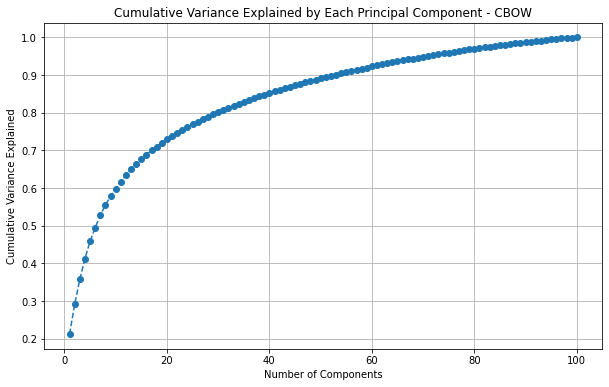

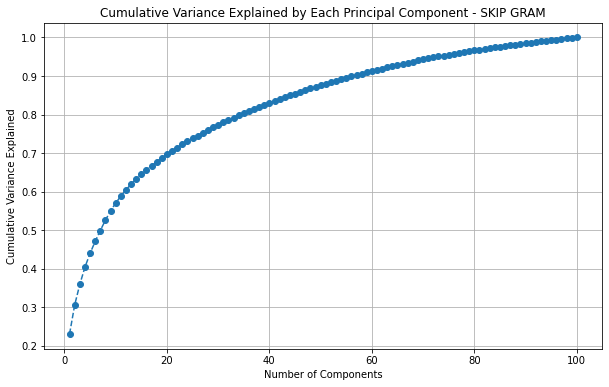

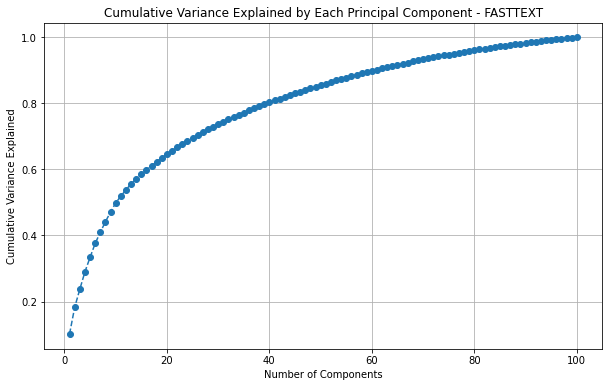

In [ ]:
pca(X_train_cbow, 'CBOW')
pca(X_train_sg, 'SKIP GRAM')
pca(X_train_fasttext, 'FASTTEXT')

• We perfomed PCA on the three different vectors: CBOW, Skip Gram, and Fasttext.

• Since all three models have a high culmulative variance: 0.95+, we are going to keep 80 components for all three models

In [ ]:
def reduce_data(n_components, X_train, X_test):
    pca = PCA(n_components=n_components)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)

    return X_train_reduced, X_test_reduced

In [ ]:
X_train_reduced_cbow, X_test_reduced_cbow = reduce_data(80, X_train_cbow, X_test_cbow)
X_train_reduced_sg, X_test_reduced_sg = reduce_data(80, X_train_sg, X_test_sg)
X_train_reduced_fasttext, X_test_reduced_fasttext = reduce_data(80, X_train_fasttext, X_test_fasttext)

### 3.4 Logistic Regression

In [ ]:
def train_and_prediction(model, X_train, X_test, y_train, y_test, report):
    model = model
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy of {model.__class__.__name__} on reduced dimensions: {accuracy}")

    if report:
        report = classification_report(y_test, predictions)
        print("Classification Report:")
        print(report)

In [ ]:
train_and_prediction(LogisticRegression(max_iter=1000), X_train_reduced_cbow, X_test_reduced_cbow, y_train, y_test, False)
train_and_prediction(LogisticRegression(max_iter=1000), X_train_reduced_sg, X_test_reduced_sg, y_train, y_test, False)
train_and_prediction(LogisticRegression(max_iter=1000), X_train_reduced_fasttext, X_test_reduced_fasttext, y_train, y_test, False)

Accuracy of LogisticRegression on reduced dimensions: 0.907139514537427
Accuracy of LogisticRegression on reduced dimensions: 0.9116970843760809
Accuracy of LogisticRegression on reduced dimensions: 0.9105373456224949


• As we can see that three differen vectors each have good performance on prediction using Logistic Regression model

In [ ]:
# Convert numpy arrays to DataFrame objects
X_train_reduced_cbow_df = pd.DataFrame(X_train_reduced_cbow)
X_train_reduced_sg_df = pd.DataFrame(X_train_reduced_sg)
X_train_reduced_fasttext_df = pd.DataFrame(X_train_reduced_fasttext)

X_test_reduced_cbow_df = pd.DataFrame(X_test_reduced_cbow)
X_test_reduced_sg_df = pd.DataFrame(X_test_reduced_sg)
X_test_reduced_fasttext_df = pd.DataFrame(X_test_reduced_fasttext)

# Concatenate DataFrame objects
X_train_reduced = pd.concat([X_train_reduced_cbow_df, X_train_reduced_sg_df, X_train_reduced_fasttext_df], axis=1)
X_test_reduced = pd.concat([X_test_reduced_cbow_df, X_test_reduced_sg_df, X_test_reduced_fasttext_df], axis=1)

In [ ]:
train_and_prediction(LogisticRegression(max_iter=1000), X_train_reduced, X_test_reduced, y_train, y_test, False)

Accuracy of LogisticRegression on reduced dimensions: 0.9158070357484385


• From the above, we combined the three vector future together for predicting, the accuracy is good but hasn't improved drastically.

• So regarding the computing power, we're using the CBOW vectors for predicting only.

#### 3.4.1 Logistic Regression prediction

In [ ]:
# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_reduced_cbow, y_train)

# Predict on the test set
predictions = model.predict(X_test_reduced_cbow)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of Logistic Regression on reduced dimensions: {accuracy}")

report = classification_report(y_test, predictions)
print("Classification Report:")
print(report)

# Add predictions to df_test for error analysis
df_test['predictions'] = predictions

Accuracy of Logistic Regression on reduced dimensions: 0.907139514537427
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.36      0.48      5836
           1       0.92      0.98      0.95     43313

    accuracy                           0.91     49149
   macro avg       0.82      0.67      0.71     49149
weighted avg       0.90      0.91      0.89     49149



#### 3.4.2 Logistic Regression Error Analysis

In [ ]:
# Now, you can directly use df_test to analyze errors
fp_reviews = df_test[(df_test['predictions'] != df_test['sentiment']) & (df_test['predictions'] == 1)]['cleaned_reviewText']
fn_reviews = df_test[(df_test['predictions'] != df_test['sentiment']) & (df_test['predictions'] == 0)]['cleaned_reviewText']

In [ ]:
# Print some examples of false positive reviews
print("Some false positive reviews:")
for i, review in enumerate(fp_reviews[:5], start=1):  # Adjust the slice as needed
    print(f"{i}: {review}\n")

# Exploring common words in false positives
fp_word_counts = Counter(" ".join(fp_reviews).split())
print("Common words in false positives:")
print(fp_word_counts.most_common(20))  # Printing top 20 common words

# Print some examples of false negative reviews
print("\nSome false negative reviews:")
for i, review in enumerate(fn_reviews[:5], start=1):  # Adjust the slice as needed
    print(f"{i}: {review}\n")

# Exploring common words in false negatives
fn_word_counts = Counter(" ".join(fn_reviews).split())
print("Common words in false negatives:")
print(fn_word_counts.most_common(20))  # Printing top 20 common words

Some false positive reviews:
1: colors gloves really nice unfortunately ever time use shower see color coming understand using first time happen several months later color coming gloves coming apart seems wont buy gloves

2: using daily almost month honest noticed change skin favor light perfumey word smell goes smoothly leave greasy look feel skin first apply skin feels smooth want think moisturize skin time skin looks feels see feel difference favor sensitive skin cause redness problems disappointed read favorable reviews hoped positive results

3: worst put together album time like real music really absolute crap like obviously white kid burbs

4: purpose spray mist dry hair energize curls full head immersion however find curly hair almost amount leaves hair w slightly crispy coated feeling purchased first bottle product salon guess changed formula expensive lesson might try buy small amount salon next time much easier purchase amazon see difference stands would recommend product

5

### 3.5 Random Forest

#### 3.5.1 Random Forest Prediction

In [ ]:
# Initialize the Random Forest classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust n_estimators as needed

# Train the model
# random_forest_model.fit(X_train, y_train)
random_forest_model.fit(X_train_reduced_cbow, y_train)


# Predict on the test set
# predictions_rf = random_forest_model.predict(X_test)
predictions_rf = random_forest_model.predict(X_test_reduced_cbow)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, predictions_rf)
print(f"Accuracy of Random Forest: {accuracy_rf}")

report = classification_report(y_test, predictions_rf)
print("Classification Report:")
print(report)

Accuracy of Random Forest: 0.8929378013794788
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.11      0.20      5836
           1       0.89      1.00      0.94     43313

    accuracy                           0.89     49149
   macro avg       0.89      0.56      0.57     49149
weighted avg       0.89      0.89      0.85     49149



#### 3.5.2 Random Forest Error Analysis

In [ ]:
# Assuming 'predictions' contains your model's predictions for X_test
df_test['predictions_rf'] = predictions_rf

# Now, you can directly use df_test to analyze errors
fp_reviews_rf = df_test[(df_test['predictions_rf'] != df_test['sentiment']) & (df_test['predictions_rf'] == 1)]['cleaned_reviewText']
fn_reviews_rf = df_test[(df_test['predictions_rf'] != df_test['sentiment']) & (df_test['predictions_rf'] == 0)]['cleaned_reviewText']

In [ ]:
# Print some examples of false positive reviews
print("Some false positive reviews:")
for i, review in enumerate(fp_reviews_rf[:5], start=1):  # Adjust the slice as needed
    print(f"{i}: {review}\n")

# Exploring common words in false positives
fp_word_counts = Counter(" ".join(fp_reviews_rf).split())
print("Common words in false positives:")
print(fp_word_counts.most_common(20))  # Printing top 20 common words

# Print some examples of false negative reviews
print("\nSome false negative reviews:")
for i, review in enumerate(fn_reviews_rf[:5], start=1):  # Adjust the slice as needed
    print(f"{i}: {review}\n")

# Exploring common words in false negatives
fn_word_counts = Counter(" ".join(fn_reviews_rf).split())
print("Common words in false negatives:")
print(fn_word_counts.most_common(20))  # Printing top 20 common words

Some false positive reviews:
1: colors gloves really nice unfortunately ever time use shower see color coming understand using first time happen several months later color coming gloves coming apart seems wont buy gloves

2: using daily almost month honest noticed change skin favor light perfumey word smell goes smoothly leave greasy look feel skin first apply skin feels smooth want think moisturize skin time skin looks feels see feel difference favor sensitive skin cause redness problems disappointed read favorable reviews hoped positive results

3: worst put together album time like real music really absolute crap like obviously white kid burbs

4: purpose spray mist dry hair energize curls full head immersion however find curly hair almost amount leaves hair w slightly crispy coated feeling purchased first bottle product salon guess changed formula expensive lesson might try buy small amount salon next time much easier purchase amazon see difference stands would recommend product

5

### 3.6 CNN Model

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_reviewText'])
word_index = tokenizer.word_index
total_vocabulary_size = len(word_index)

print(f'Total vocabulary size: {total_vocabulary_size}')

Total vocabulary size: 146167


In [ ]:
sequences = tokenizer.texts_to_sequences(df['cleaned_reviewText'])
sequence_lengths = [len(sequence) for sequence in sequences]

# Analyze the distribution of sequence lengths
print(f'Maximum sequence length: {max(sequence_lengths)}')
print(f'Mean sequence length: {np.mean(sequence_lengths)}')
print(f'Median sequence length: {np.median(sequence_lengths)}')

# You can also use percentile to determine a more flexible maxlen
percentile_length = np.percentile(sequence_lengths, 95)  # For example, the 95th percentile
print(f'95th percentile of sequence length: {percentile_length}')

Maximum sequence length: 2468
Mean sequence length: 59.47036107120912
Median sequence length: 35.0
95th percentile of sequence length: 190.0


#### 3.6.1 CNN model with CBOW vectors

In [ ]:
embedding_dim = 100  # The dimensionality of your Word2Vec/FastText embeddings
vocabulary_size = len(word_index) + 1
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model_cbow.wv:  # Check if the word is in the model's vocabulary
        embedding_vector = w2v_model_cbow.wv[word]  # Correct way to access the vector
        embedding_matrix[i] = embedding_vector

maxlen = 125  # Maximum length of all sequences
X = pad_sequences(sequences, maxlen=maxlen)
y = df['sentiment'].values

##### 3.6.1.1 Prediction

In [ ]:
# Split data into train, val, and test sets while retaining indices
X_train, X_temp, y_train, y_temp, indices_train, indices_temp = train_test_split(
    X, y, range(len(y)), test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test, indices_val, indices_test = train_test_split(
    X_temp, y_temp, indices_temp, test_size=0.1, random_state=42)  # 20% of 80% = 0.2

# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim,
                    weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

adam_optimizer = Adam(learning_rate=0.1)
model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Model summary to see the architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 125, 100)          14616800  
                                                                 
 conv1d_1 (Conv1D)           (None, 121, 128)          64128     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14681057 (56.00 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 14616800 (55.76 MB)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
6144/6144 [==============================] - 33s 5ms/step - loss: 1.2365 - accuracy: 0.8608 - val_loss: 0.6256 - val_accuracy: 0.8742
Epoch 2/100
6144/6144 [==============================] - 30s 5ms/step - loss: 0.7073 - accuracy: 0.8765 - val_loss: 0.5959 - val_accuracy: 0.8771
Epoch 3/100
6144/6144 [==============================] - 30s 5ms/step - loss: 0.5797 - accuracy: 0.8795 - val_loss: 0.4550 - val_accuracy: 0.8803
Epoch 4/100
6144/6144 [==============================] - 30s 5ms/step - loss: 0.4983 - accuracy: 0.8809 - val_loss: 0.5945 - val_accuracy: 0.8790
Epoch 5/100
6144/6144 [==============================] - 30s 5ms/step - loss: 0.4645 - accuracy: 0.8812 - val_loss: 0.4357 - val_accuracy: 0.8803
Epoch 6/100
6144/6144 [==============================] - 30s 5ms/step - loss: 0.4439 - accuracy: 0.8816 - val_loss: 0.4808 - val_accuracy: 0.8780
Epoch 7/100
6144/6144 [==============================] - 30s 5ms/step - loss: 0.4262 - accuracy: 0.8819 - val_loss: 0.4501 -

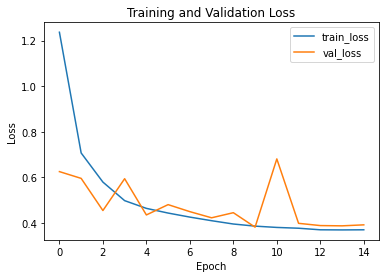

In [ ]:
# Plot train and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Test the model accuracy on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Print classification report
y_pred_prob = model.predict(X_test)
predictions_cnn = np.where(y_pred_prob > 0.5, 1, 0)
print("Classification Report:")
print(classification_report(y_test, predictions_cnn))

154/154 [==============================] - 1s 3ms/step - loss: 0.3981 - accuracy: 0.8802
Test Loss: 0.3981
Test Accuracy: 0.8802
154/154 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       589
           1       0.88      1.00      0.94      4326

    accuracy                           0.88      4915
   macro avg       0.44      0.50      0.47      4915
weighted avg       0.77      0.88      0.82      4915



/home/xiong.ru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiong.ru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiong.ru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 3.6.1.2 Error Analysis

In [ ]:
# Create a new df_test that corresponds to X_test
df_test_cnn = df.iloc[indices_test].reset_index(drop=True)
# Add predictions to df_test_cnn
df_test_cnn['predictions'] = predictions_cnn

In [ ]:
# Identify false positives and false negatives
fp_reviews_cnn = df_test_cnn[(df_test_cnn['predictions'] == 1) & (df_test_cnn['sentiment'] == 0)]['cleaned_reviewText']
fn_reviews_cnn = df_test_cnn[(df_test_cnn['predictions'] == 0) & (df_test_cnn['sentiment'] == 1)]['cleaned_reviewText']

# Print some examples and analyze common words
print("Some false positive reviews (CNN):")
print(fp_reviews_cnn.head().to_string(index=False), "\n")

print("Some false negative reviews (CNN):")
print(fn_reviews_cnn.head().to_string(index=False), "\n")

# Common words in false positives
fp_word_counts_cnn = Counter(" ".join(fp_reviews_cnn).split())
print("Common words in false positives (CNN):")
print(fp_word_counts_cnn.most_common(20))

# Common words in false negatives
fn_word_counts_cnn = Counter(" ".join(fn_reviews_cnn).split())
print("Common words in false negatives (CNN):")
print(fn_word_counts_cnn.most_common(20))

Some false positive reviews (CNN):
found product difficult use despite long hair p...
really excited get based reviews price however ...
recently borrowed cd local library whereas mr c...
toni guy new brand decided try plumping whip ha...
son reports spring break remember post rating p... 

Some false negative reviews (CNN):
Series([], ) 

Common words in false positives (CNN):
[('hair', 410), ('like', 358), ('product', 335), ('one', 265), ('would', 212), ('good', 187), ('album', 182), ('skin', 182), ('use', 178), ('really', 177), ('get', 173), ('even', 158), ('much', 143), ('using', 136), ('time', 135), ('well', 123), ('work', 119), ('used', 119), ('first', 113), ('also', 109)]
Common words in false negatives (CNN):
[]


#### 3.6.2 CNN model with Skip Gram vectors

In [ ]:
embedding_dim = 100  # The dimensionality of your Word2Vec/FastText embeddings
vocabulary_size = len(word_index) + 1
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model_sg.wv:  # Check if the word is in the model's vocabulary
        embedding_vector = w2v_model_sg.wv[word]  # Correct way to access the vector
        embedding_matrix[i] = embedding_vector

maxlen = 125  # Maximum length of all sequences
X = pad_sequences(sequences, maxlen=maxlen)
y = df['sentiment'].values


# Split data while retaining indices
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split( X, y, range(len(y)), test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim,
                    weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

adam_optimizer = Adam(learning_rate=0.1)
model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Model summary to see the architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 125, 100)          14616800  
                                                                 
 conv1d_2 (Conv1D)           (None, 121, 128)          64128     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14681057 (56.00 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 14616800 (55.76 MB)
_________________________________________________________________


##### 3.6.2.1 Prediction

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model on the test data
# ann_loss, ann_accuracy = ann_model.evaluate(X_test.toarray(), y_test_one_hot)
cnn_loss, cnn_accuracy_sg = model.evaluate(X_test, y_test)
print("CNN Accuracy:", cnn_accuracy_sg)

Epoch 1/10
6144/6144 [==============================] - 28s 4ms/step - loss: 0.3272 - accuracy: 0.8819
Epoch 2/10
6144/6144 [==============================] - 27s 4ms/step - loss: 0.3270 - accuracy: 0.8823
Epoch 3/10
6144/6144 [==============================] - 27s 4ms/step - loss: 0.3246 - accuracy: 0.8822
Epoch 4/10
6144/6144 [==============================] - 27s 4ms/step - loss: 0.3281 - accuracy: 0.8823
Epoch 5/10
6144/6144 [==============================] - 27s 4ms/step - loss: 0.3320 - accuracy: 0.8822
Epoch 6/10
6144/6144 [==============================] - 27s 4ms/step - loss: 0.3349 - accuracy: 0.8823
Epoch 7/10
6144/6144 [==============================] - 27s 4ms/step - loss: 0.3488 - accuracy: 0.8822
Epoch 8/10
6144/6144 [==============================] - 27s 4ms/step - loss: 0.3571 - accuracy: 0.8823
Epoch 9/10
6144/6144 [==============================] - 27s 4ms/step - loss: 0.3638 - accuracy: 0.8823
Epoch 10/10
1536/1536 [==============================] - 4s 2ms/step - lo

In [ ]:
# Test the model accuracy on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Print classification report
y_pred_prob_sg = model.predict(X_test)
predictions_cnn_sg = np.where(y_pred_prob_sg > 0.5, 1, 0)
print("Classification Report:")
print(classification_report(y_test, predictions_cnn_sg))

1536/1536 [==============================] - 4s 3ms/step - loss: 0.3679 - accuracy: 0.8813
Test Loss: 0.3679
Test Accuracy: 0.8813
1536/1536 [==============================] - 4s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5836
           1       0.88      1.00      0.94     43313

    accuracy                           0.88     49149
   macro avg       0.44      0.50      0.47     49149
weighted avg       0.78      0.88      0.83     49149



/home/xiong.ru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiong.ru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiong.ru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 3.6.2.2 Error Analysis

In [ ]:
# Create a new df_test that corresponds to X_test
df_test_cnn_sg = df.iloc[indices_test].reset_index(drop=True)

# Assuming you've already made predictions with your CNN
predictions_proba = model.predict(X_test)
predictions_cnn_sg = (predictions_proba > 0.5).astype("int32").flatten()

# Add predictions to df_test_cnn
df_test_cnn_sg['predictions'] = predictions_cnn_sg

1536/1536 [==============================] - 4s 2ms/step


In [ ]:
# Identify false positives and false negatives
fp_reviews_cnn_sg = df_test_cnn_sg[(df_test_cnn_sg['predictions'] == 1) & (df_test_cnn_sg['sentiment'] == 0)]['cleaned_reviewText']
fn_reviews_cnn_sg = df_test_cnn_sg[(df_test_cnn_sg['predictions'] == 0) & (df_test_cnn_sg['sentiment'] == 1)]['cleaned_reviewText']

# Print some examples and analyze common words
print("Some false positive reviews (CNN):")
print(fp_reviews_cnn_sg.head().to_string(index=False), "\n")

print("Some false negative reviews (CNN):")
print(fn_reviews_cnn_sg.head().to_string(index=False), "\n")

# Common words in false positives
fp_word_counts_cnn_sg = Counter(" ".join(fp_reviews_cnn_sg).split())
print("Common words in false positives (CNN):")
print(fp_word_counts_cnn_sg.most_common(20))

# Common words in false negatives
fn_word_counts_cnn_sg = Counter(" ".join(fn_reviews_cnn_sg).split())
print("Common words in false negatives (CNN):")
print(fn_word_counts_cnn_sg.most_common(20))

Some false positive reviews (CNN):
tried firming skin basically good moisturizer n...
colors gloves really nice unfortunately ever ti...
using daily almost month honest noticed change ...
worst put together album time like real music r...
purpose spray mist dry hair energize curls full... 

Some false negative reviews (CNN):
Series([], ) 

Common words in false positives (CNN):
[('hair', 3704), ('like', 3678), ('product', 3166), ('one', 2307), ('would', 1988), ('skin', 1913), ('use', 1884), ('album', 1782), ('get', 1781), ('good', 1773), ('even', 1620), ('really', 1566), ('used', 1370), ('much', 1277), ('time', 1209), ('using', 1187), ('well', 1116), ('work', 1086), ('quot', 1044), ('better', 1029)]
Common words in false negatives (CNN):
[]


### 3.7 LSTM

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim,
                    weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

adam_optimizer = Adam(learning_rate=0.1)
model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Model summary to see the architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 125, 100)          14616800  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14659105 (55.92 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 14616800 (55.76 MB)
_________________________________________________________________


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model on the test data
LSTM_loss, LSTM_accuracy_sg = model.evaluate(X_test, y_test)
print("LSTM Accuracy:", LSTM_accuracy_sg)

Epoch 1/10
6144/6144 [==============================] - 288s 46ms/step - loss: 0.3656 - accuracy: 0.8819
Epoch 2/10
6144/6144 [==============================] - 284s 46ms/step - loss: 0.3623 - accuracy: 0.8818
Epoch 3/10
6144/6144 [==============================] - 285s 46ms/step - loss: 0.3609 - accuracy: 0.8827
Epoch 4/10
6144/6144 [==============================] - 285s 46ms/step - loss: 0.3632 - accuracy: 0.8832
Epoch 5/10
6144/6144 [==============================] - 284s 46ms/step - loss: 0.3622 - accuracy: 0.8836
Epoch 6/10
6144/6144 [==============================] - 284s 46ms/step - loss: 0.3656 - accuracy: 0.8831
Epoch 7/10
6144/6144 [==============================] - 285s 46ms/step - loss: 0.3632 - accuracy: 0.8828
Epoch 8/10
6144/6144 [==============================] - 286s 47ms/step - loss: 0.3638 - accuracy: 0.8836
Epoch 9/10
6144/6144 [==============================] - 285s 46ms/step - loss: 0.3650 - accuracy: 0.8819
Epoch 10/10
1536/1536 [==============================] 

In [ ]:
# Test the model accuracy on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Print classification report
y_pred_prob_sg = model.predict(X_test)
predictions_lstm_sg = np.where(y_pred_prob_sg > 0.5, 1, 0)
print("Classification Report:")
print(classification_report(y_test, predictions_lstm_sg))

1536/1536 [==============================] - 13s 9ms/step - loss: 0.3571 - accuracy: 0.8858
Test Loss: 0.3571
Test Accuracy: 0.8858
1536/1536 [==============================] - 13s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.08      0.14      5836
           1       0.89      0.99      0.94     43313

    accuracy                           0.89     49149
   macro avg       0.78      0.54      0.54     49149
weighted avg       0.86      0.89      0.84     49149



### 3.8 VADER

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/xiong.ru/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Apply VADER to analyze the sentiments of reviews
df['scores'] = df['cleaned_reviewText'].apply(lambda review: sid.polarity_scores(review))
df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['vader_sentiment'] = df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

# Display the dataframe to verify the results
df[['cleaned_reviewText', 'compound', 'vader_sentiment']].head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/xiong.ru/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,cleaned_reviewText,compound,vader_sentiment
0,oily creamy expected ordered try highlight con...,-0.1531,neg
2,texture concealer pallet fantastic great cover...,0.9679,pos
3,really tell exactly thing powder kind oil ish ...,0.5267,pos
5,happy get palette wish offered subscription fo...,0.9872,pos
6,please dont rachett palette size like picture ...,0.8481,pos


In [ ]:
# Convert 'vader_sentiment' from 'pos'/'neg' to 1/0 to match 'sentiment'
df['vader_sentiment_binary'] = df['vader_sentiment'].apply(lambda x: 1 if x == 'pos' else 0)
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy_vader = accuracy_score(df['sentiment'], df['vader_sentiment_binary'])

print(f"Accuracy of VADER sentiment analysis: {accuracy_vader}")

Accuracy of VADER sentiment analysis: 0.8780830223690796


In [ ]:
# Identify false positives and false negatives
fp_vader = df[(df['vader_sentiment_binary'] == 1) & (df['sentiment'] == 0)]
fn_vader = df[(df['vader_sentiment_binary'] == 0) & (df['sentiment'] == 1)]

In [ ]:
from collections import Counter

# Print some examples of false positive reviews
print("Some false positive reviews (VADER):")
for i, text in enumerate(fp_vader['cleaned_reviewText'].head(5), 1):  # Adjust as needed
    print(f"{i}: {text}\n")

# Analyze common words in false positives
fp_vader_words = Counter(" ".join(fp_vader['cleaned_reviewText']).split())
print("Common words in false positives (VADER):")
print(fp_vader_words.most_common(20))  # Top 20 common words


# Print some examples of false negative reviews
print("Some false negative reviews (VADER):")
for i, text in enumerate(fn_vader['cleaned_reviewText'].head(5), 1):  # Adjust as needed
    print(f"{i}: {text}\n")

# Analyze common words in false negatives
fn_vader_words = Counter(" ".join(fn_vader['cleaned_reviewText']).split())
print("\nCommon words in false negatives (VADER):")
print(fn_vader_words.most_common(20))  # Top 20 common words

Some false positive reviews (VADER):
1: really tell exactly thing powder kind oil ish pasty fluid far tried twice doesnt really show color face

2: please dont rachett palette size like picture colors go sheer slides face like wax expect makeup stay put one spend money good stuff thumbs

3: chalky pigmented wears easily coastal scents dupe many highlighter colors show dark skinned women would recommend coastal scents currently sale worth extra bucks

4: nothing skin used suggested signs brightness wish worked

5: gell nothing religiously put specific areas weeks nothing changed waste time

Common words in false positives (VADER):
[('like', 16017), ('hair', 15534), ('product', 12445), ('one', 9276), ('would', 8159), ('skin', 7699), ('good', 7607), ('use', 7407), ('album', 7110), ('get', 6828), ('really', 6712), ('even', 6009), ('much', 5435), ('used', 5422), ('well', 4854), ('better', 4783), ('time', 4750), ('using', 4701), ('quot', 4463), ('work', 4410)]
Some false negative reviews (VA

### 3.9 TEXTBLOB

In [ ]:
!pip install textblob

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for textblob from https://files.pythonhosted.org/packages/02/07/5fd2945356dd839974d3a25de8a142dc37293c21315729a41e775b5f3569/textblob-0.18.0.post0-py3-none-any.whl.metadata
  Obtaining dependency information for nltk>=3.8 from https://files.pythonhosted.org/packages/a6/0a/0d20d2c0f16be91b9fa32a77b76c60f9baf6eba419e5ef5deca17af9c582/nltk-3.8.1-py3-none-any.whl.metadata
  Obtaining dependency information for regex>=2021.8.3 from https://files.pythonhosted.org/packages/eb/10/4ccc8eed80f11c082a2883d49d4090aa80c7f65704216a529f490cb089b1/regex-2023.12.25-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 324.3 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 5.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.5 MB/s eta 0:00:0000:01
   ━━

In [ ]:
from textblob import TextBlob

# df['textblob_sentiment'] = df['cleaned_reviewText'].apply(lambda text: TextBlob(text).sentiment.polarity)
# df['textblob_sentiment_label'] = df['textblob_sentiment'].apply(lambda score: 'pos' if score >= 0 else 'neg')
# df[['cleaned_reviewText', 'textblob_sentiment', 'textblob_sentiment_label']]

df['textblob_sentiment'] = df['cleaned_reviewText'].apply(lambda text: TextBlob(text).sentiment.polarity)
df['textblob_subjectivity'] = df['cleaned_reviewText'].apply(lambda text: TextBlob(text).sentiment.subjectivity)

# Label the sentiment as 'pos' or 'neg' based on the polarity
df['textblob_sentiment_label'] = df['textblob_sentiment'].apply(lambda score: 'pos' if score >= 0 else 'neg')

# Display the DataFrame with the new columns
df[['cleaned_reviewText', 'textblob_sentiment', 'textblob_sentiment_label', 'textblob_subjectivity']]

,cleaned_reviewText,textblob_sentiment,textblob_sentiment_label,textblob_subjectivity
0,oily creamy expected ordered try highlight con...,-0.550000,neg,0.700000
2,texture concealer pallet fantastic great cover...,0.213333,pos,0.465994
3,really tell exactly thing powder kind oil ish ...,0.225000,pos,0.441667
5,happy get palette wish offered subscription fo...,0.341026,pos,0.600000
6,please dont rachett palette size like picture ...,0.350000,pos,0.675000
...,...,...,...,...
276475,simple perfect plenty big enough durable tough...,0.286111,pos,0.633883
276476,claws fantastic made hard sturdy plastic wheth...,0.206481,pos,0.587963
276477,really like theseouddy heat resistant meat cla...,0.385417,pos,0.633333
276478,make pulled pork crock pot pretty often always...,0.069862,pos,0.603634


In [ ]:
df['textblob_sentiment_binary'] = df['textblob_sentiment_label'].apply(lambda x: 1 if x == 'pos' else 0)
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy_textblob = accuracy_score(df['sentiment'], df['textblob_sentiment_binary'])

print(f"Accuracy of Textblob sentiment analysis: {accuracy_textblob}")

Accuracy of Textblob sentiment analysis: 0.8742619261743054


In [ ]:
from collections import Counter

# Identify false positives and false negatives
fp_textblob = df[(df['textblob_sentiment_binary'] == 1) & (df['sentiment'] == 0)]
fn_textblob = df[(df['textblob_sentiment_binary'] == 0) & (df['sentiment'] == 1)]

# Print examples of false positive reviews
print("Some false positive reviews (TextBlob):")
for i, text in enumerate(fp_textblob['cleaned_reviewText'].head(5), 1):  # Adjust the slice as needed
    print(f"{i}: {text}\n")

# Common words in false positives
fp_textblob_words = Counter(" ".join(fp_textblob['cleaned_reviewText']).split())
print("Common words in false positives (TextBlob):")
print(fp_textblob_words.most_common(20))  # Top 20 common words

# Print examples of false negative reviews
print("Some false negative reviews (TextBlob):")
for i, text in enumerate(fn_textblob['cleaned_reviewText'].head(5), 1):  # Adjust the slice as needed
    print(f"{i}: {text}\n")

# Common words in false negatives
fn_textblob_words = Counter(" ".join(fn_textblob['cleaned_reviewText']).split())
print("\nCommon words in false negatives (TextBlob):")
print(fn_textblob_words.most_common(20))  # Top 20 common words

Some false positive reviews (TextBlob):
1: really tell exactly thing powder kind oil ish pasty fluid far tried twice doesnt really show color face

2: please dont rachett palette size like picture colors go sheer slides face like wax expect makeup stay put one spend money good stuff thumbs

3: chalky pigmented wears easily coastal scents dupe many highlighter colors show dark skinned women would recommend coastal scents currently sale worth extra bucks

4: nothing skin used suggested signs brightness wish worked

5: perfume wearer heard light unlike perfume got roll care like perfumes makes nauseated giving relative christmas

Common words in false positives (TextBlob):
[('like', 14130), ('hair', 13929), ('product', 11649), ('one', 8969), ('good', 7718), ('would', 7684), ('skin', 7596), ('use', 7135), ('album', 6984), ('get', 6600), ('really', 6516), ('even', 5605), ('much', 5320), ('used', 5155), ('better', 4714), ('time', 4637), ('using', 4535), ('well', 4419), ('quot', 4274), ('firs

## 4. Comparison

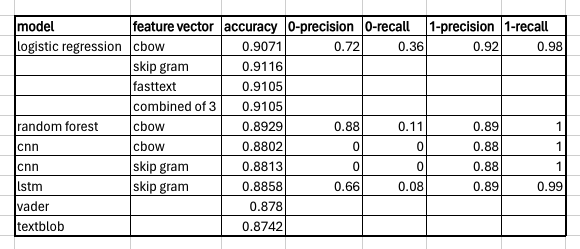


### 4.1 Compare various methods

1. From the above table, we can see that **logistic regression** is the best performing model. We think the averaged vector makes it perfect for logistic regression to work on the feature space; Since each vector space is the coordinates of the sentence word vector on high-demension space

3. The worst performing model is CNN if we look at the classification report. CNN didn't work at all and the high accuracy was purely due to the data imbalance; Talking about which, we think it totally makes sense that CNN is the worst performing model:

  • CNN model are not that good working with sequence data

  • The model only has one convolutional layer, which is not perfert for feature extraction

4. We think LSTM still get potential of better performance. However, since the dataset was huge and it took very long to train each epoch, we haven't processed with tuning the LSTM model. If possible, we should adjust the learning_rate to smaller number and keep training the model. With more epoches and good training_rate applied, we believe LSTM can achiever better performance.


### 4.2 Analyze SA on the test data

1. Looking at the accuracy, we'll falsely think that our model is performing well. However, if we look at the classification report in detail, we'll realize that the high accuracy didn't mean everything.

2. In most models, the precision and recall for class of label 1 are good in almost all models. However, the precision and recall for class of label 0 are not that good. Especially the recall for label 0 are very low across all models.

  • Common low recall for label 0: indicates that out of all the instances that truly belong to class 0, only a small amount were correctly identified by the model;

  • This could imply that the model has a tendency to incorrectly classify instances of class 0 as class 1;

  • This tells us that we should take a deeper look at the false positive instances in detail to find the pattern for mislabelling.

3. As mentioned above, the CNN model is not working at all and the high accuracy is only due to data imbalance.

### 4.3 Patterns of instances where model went wrong

**Error Analysis for Logistic Regression**

Words such as "like," "one," "use," "really," "even," and "well" appear frequently in both categories. These words can be used in both positive and negative contexts, possibly confusing the model.


 Interestingly, the lists don't include many strongly positive or negative words (e.g., "amazing," "terrible"), suggesting the model might be missing cues from more emotionally charged language.

**Error Analysis for Random Forest**

The false positive reviews tend to be longer and more detailed. This complexity could confuse the model, especially if it relies heavily on keyword spotting rather than understanding the overall context.

Words common in everyday language ("like," "one," "even") are prevalent in both false positives and negatives. Their high frequency may dilute the impact of more sentiment-bearing words in the model's decision-making proce

**Error Analysis for CNN**

CNN has predicted everything into class 1. We think the mistake was largely made by the maxpooling layer. Maxpooling filtered the value so that only the max number was stored, which can easily filter out all the negative sentiment.

**Error Analysis for VADER**

The most common words in both false positives and negatives include terms like "like," "hair," "product," which are relatively neutral. Their prevalence suggests that the sentiment conveyed in the context of their use may not be adequately captured by VADER.

The lists of common words do not heavily feature words with strong sentiment, which may point towards VADER's challenges in detecting subtler expressions of sentiment.

The false positives and negatives contain descriptive language about the product or experience but may not use overtly positive or negative words that VADER easily recognizes.

**Error Analysis for TextBlob**

TextBlob, like VADER, is a rule-based sentiment analysis tool that might not capture the nuances in product reviews or other complex texts without contextual understanding

Similar to VADER, the most common words in both false positives and negatives are relatively neutral, like "like," "one," "use," which may not carry strong sentiment signals. This could contribute to the misclassification.

The lists lack strongly sentiment-charged words, suggesting that TextBlob may struggle with subtleties in sentiment expression, especially when sentiment is implied rather than explicitly stated.

Both false positive and negative reviews are descriptive about the products or experiences but might not explicitly express sentiment in a way that TextBlob easily recognizes.